
## HySWAN Metamodel: Waves dataset propagation to a point.

This is a very simplified example of HySWAN toolbox. 

A waves series dataset will be propagated to a coastal point using the statistical-numerical metamodel, reducing number of SWAN cases to execute, and therefore computational resources required.

SWAN scenario is a demo case based on Roi-namur (Kwajalein atoll).

<strong>Workflow</strong>:


- Generate a waves subset using Maximum Dissimilarity Algorithm (MDA) classification from waves series dataset.
- Numerical solve waves propagations, using MDA waves subset as SWAN boundary conditions. Store propagated waves at a point.
- Feed SWAN input / output to a Radial Basis Functions model.
- Use RBF interpolator to statistically reconstruct propagation for the entire waves series dataset.


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# dev library
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# swan wrap module
from hywaves.swan.wrap import SwanProject, SwanWrap_STAT
from hywaves.swan.plots.stat import scatter_maps

# statistics
from hywaves.mda import MaxDiss_Simplified_NoThreshold
from hywaves.rbf import RBF_Reconstruction, RBF_Validation

# plotting
from hywaves.plotting.mda import Plot_MDA_Data



## Database

In [2]:
# --------------------------------------
# data
p_data = op.abspath(op.join(os.path.abspath(''), '..', '..', 'data'))
p_demo = op.join(p_data, 'demo', 'nb_demo_roi')

# swan main and nest1 mesh
p_swan_ext = op.join(p_demo, 'Roinamur_ext_bottom.dat')
p_swan_int = op.join(p_demo, 'Roinamur_int_bottom.dat')

# waves data
p_waves = op.join(p_demo, 'waves_historical.nc')

# roi shore (for plots)
p_shore = op.join(p_demo, 'shore.npy')
np_shore = np.load(p_shore)


In [3]:
# load waves dataset
dataset = xr.open_dataset(p_waves)  # > 300000 waves cases

# prepare waves data for SWAN STATIONARY 
dataset = dataset[['Hs', 'Tp', 'Dir']].to_dataframe()[1:]
dataset.rename(columns={"Hs":"hs", "Tp":"tp", "Dir": "dir"}, inplace=True)

print(dataset)


                                     hs        tp        dir
time                                                        
1979-01-01 00:59:59.999986560  0.526302  2.780521  68.265551
1979-01-01 02:00:00.000013440  0.836201  3.526751  70.859670
1979-01-01 03:00:00.000000000  1.063496  4.161158  73.547036
1979-01-01 03:59:59.999986560  1.221201  4.587750  74.101988
1979-01-01 05:00:00.000013440  1.346811  4.950551  73.434447
...                                 ...       ...        ...
2020-06-30 20:00:00.000013312  0.978911  8.029230  63.577090
2020-06-30 21:00:00.000000000  0.976827  8.030317  62.778190
2020-06-30 21:59:59.999986688  0.973691  8.029948  62.099051
2020-06-30 23:00:00.000013312  0.970341  8.023516  61.521886
2020-07-01 00:00:00.000000000  0.967821  8.014340  61.103933

[363768 rows x 3 columns]



## Maximum Dissimilarity Algorithm (MDA) classification

In [4]:
# --------------------------------------
# Set MDA parameters

# variables to use
vns = ['hs', 'tp', 'dir']

# subset size, scalar and directional indexes
n_subset = 125            # subset size (very small for this conceptual example)
ix_scalar = [0, 1]        # hs, tp
ix_directional = [2]      # dir



MaxDiss waves parameters: 363768 --> 125

   MDA centroids: 125/125



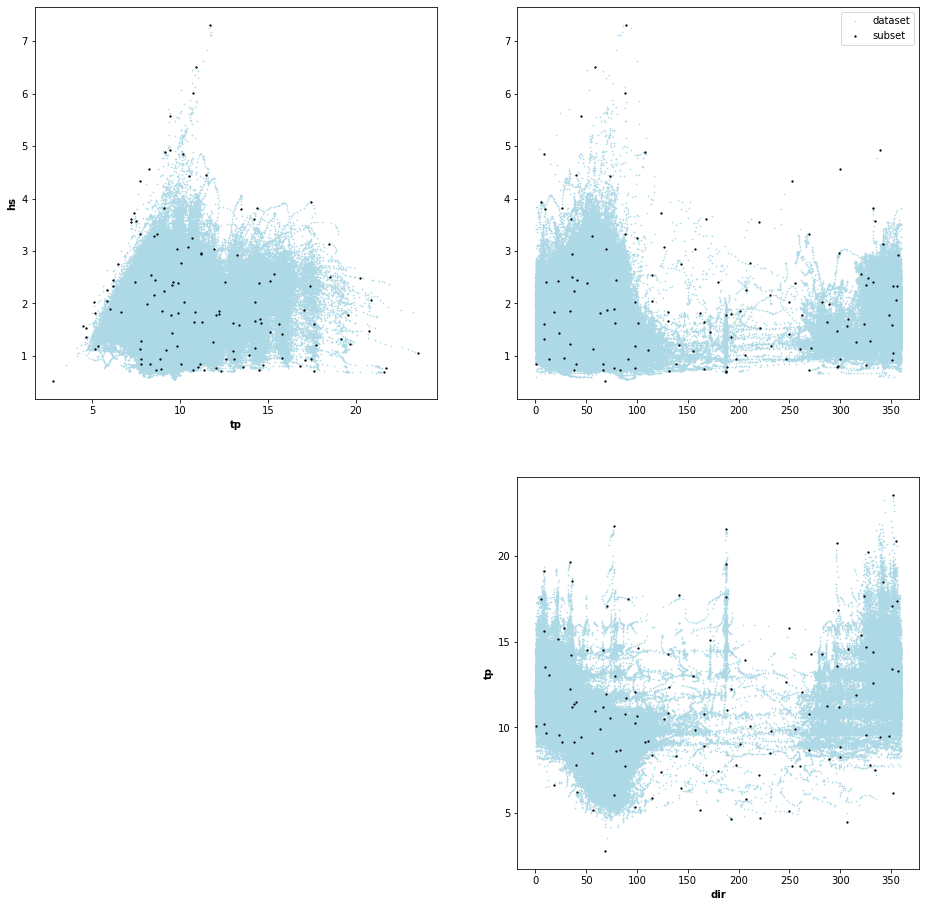

In [5]:
# MDA algorithm
sel = MaxDiss_Simplified_NoThreshold(dataset[vns].values[:], n_subset, ix_scalar, ix_directional)
subset = pd.DataFrame(data=sel, columns=vns)

# plot classification
Plot_MDA_Data(dataset, subset);


## SWAN: main and nested grid descriptions

In [6]:
main_grid = {
    'xpc': 166.6159,  # x origin
    'ypc': 8.4105,    # y origin
    'alpc': 0,        # x-axis direction 
    'xlenc': 1.3722,  # grid length in x
    'ylenc': 1.175,   # grid length in y
    'mxc': 137,       # number mesh x
    'myc': 118,       # number mesh y
    'dxinp': 0.01,    # size mesh x
    'dyinp': 0.01,    # size mesh y
}

nested_grid = {
    'xpc': 167.4059,
    'ypc': 9.3505,
    'alpc': 0,
    'xlenc': 0.12,
    'ylenc': 0.08,
    'mxc': 120,
    'myc': 80,
    'dxinp': 0.001,
    'dyinp': 0.001,
}

## SWAN: Build and launch waves cases

In [7]:
# fill subset variables
subset['spr'] = 40  # directional spread
subset.rename(columns={'tp':'per'}, inplace=True)  # rename Tp for swan wrapper


# swan project
p_proj = op.join(p_data, 'projects')
n_proj = 'nb_demo_roi'
sp = SwanProject(p_proj, n_proj)


# main mesh: depth and computational grid 
sp.mesh_main.dg = main_grid.copy()
sp.mesh_main.cg = main_grid.copy()
sp.mesh_main.depth = np.loadtxt(p_swan_ext)

# nested mesh: depth and computational grid 
sp.mesh_nest1.dg = nested_grid.copy()
sp.mesh_nest1.cg = nested_grid.copy()
sp.mesh_nest1.depth = np.loadtxt(p_swan_int)

# activate nested mesh
sp.run_nest1 = True


# SWAN parameters 
sp.params = {
    'sea_level': 0,
    'jonswap_gamma': 10,
    'coords_spherical': 'CCM',
    'waves_period': 'PEAK',
    'nested_bounds': 'CLOSED',
}

    
# SWAN project wrapper
sw = SwanWrap_STAT(sp)

# build and launch cases
#sw.build_cases(subset)
#sw.run_cases()


## SWAN: output visualization

<xarray.Dataset>
Dimensions:  (case: 125, lat: 118, lon: 137)
Coordinates:
  * lat      (lat) float64 8.411 8.42 8.43 8.44 8.45 ... 9.546 9.556 9.566 9.576
  * lon      (lon) float64 166.6 166.6 166.6 166.6 ... 167.9 168.0 168.0 168.0
Dimensions without coordinates: case
Data variables:
    Hsig     (case, lon, lat) float32 5.9802556 5.953358 ... 1.0322323 1.0408063
    Tm02     (case, lon, lat) float32 10.299339 10.58462 ... 4.2796555 4.1737323
    Dir      (case, lon, lat) float32 109.63545 109.62372 ... 212.33855
    Dspr     (case, lon, lat) float32 29.84717 29.974876 ... 47.923607 48.39101
    TPsmoo   (case, lon, lat) float32 11.748389 11.748579 ... 4.7350216 4.73372


/Users/nico/Projects/BlueMath/HyWaves/venv/lib/python3.7/site-packages/matplotlib/colors.py:1061: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


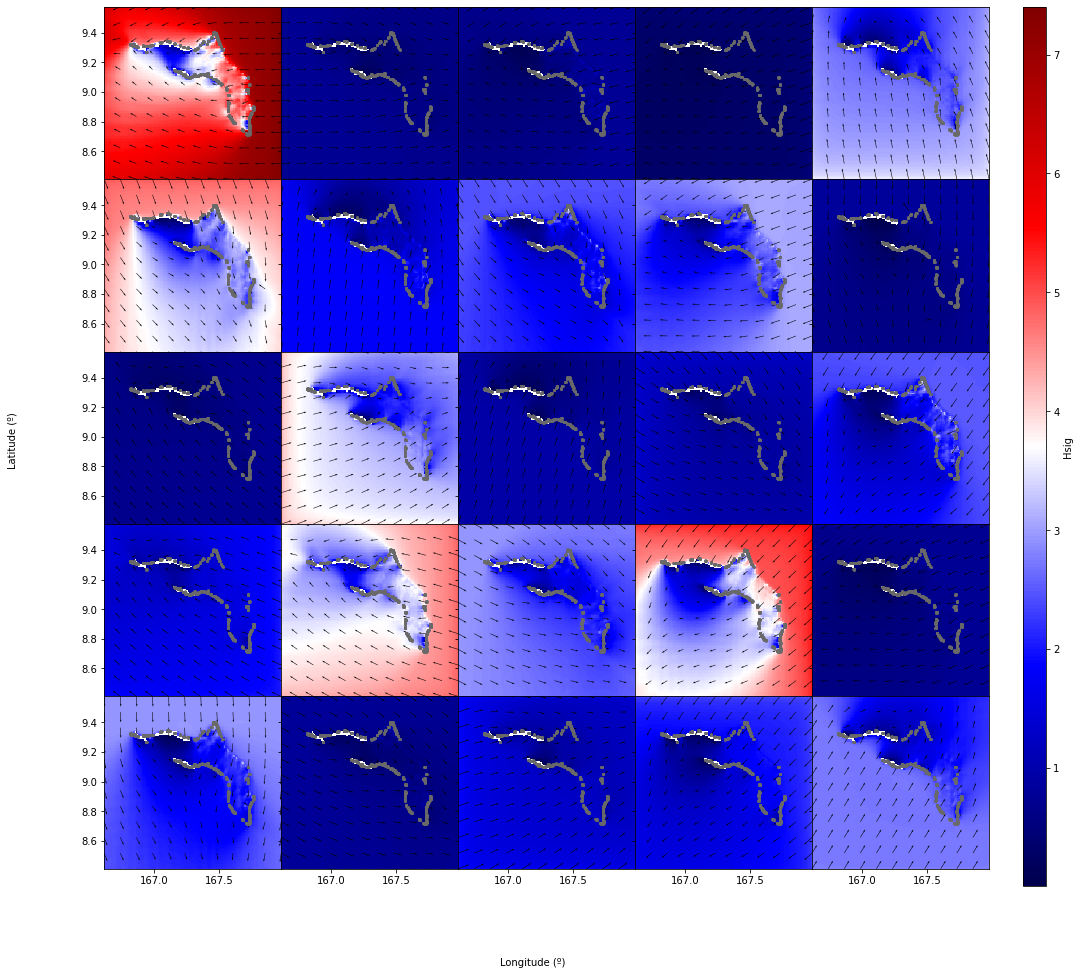

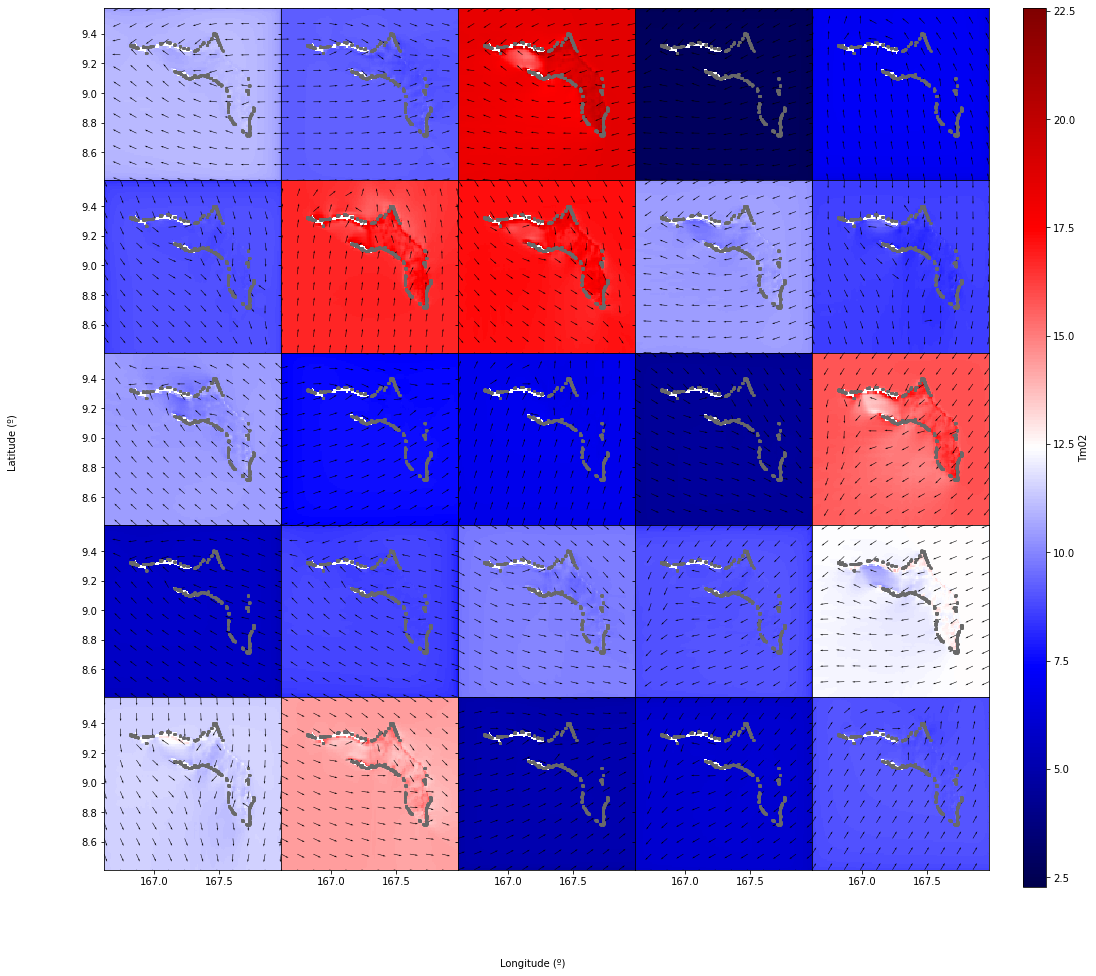

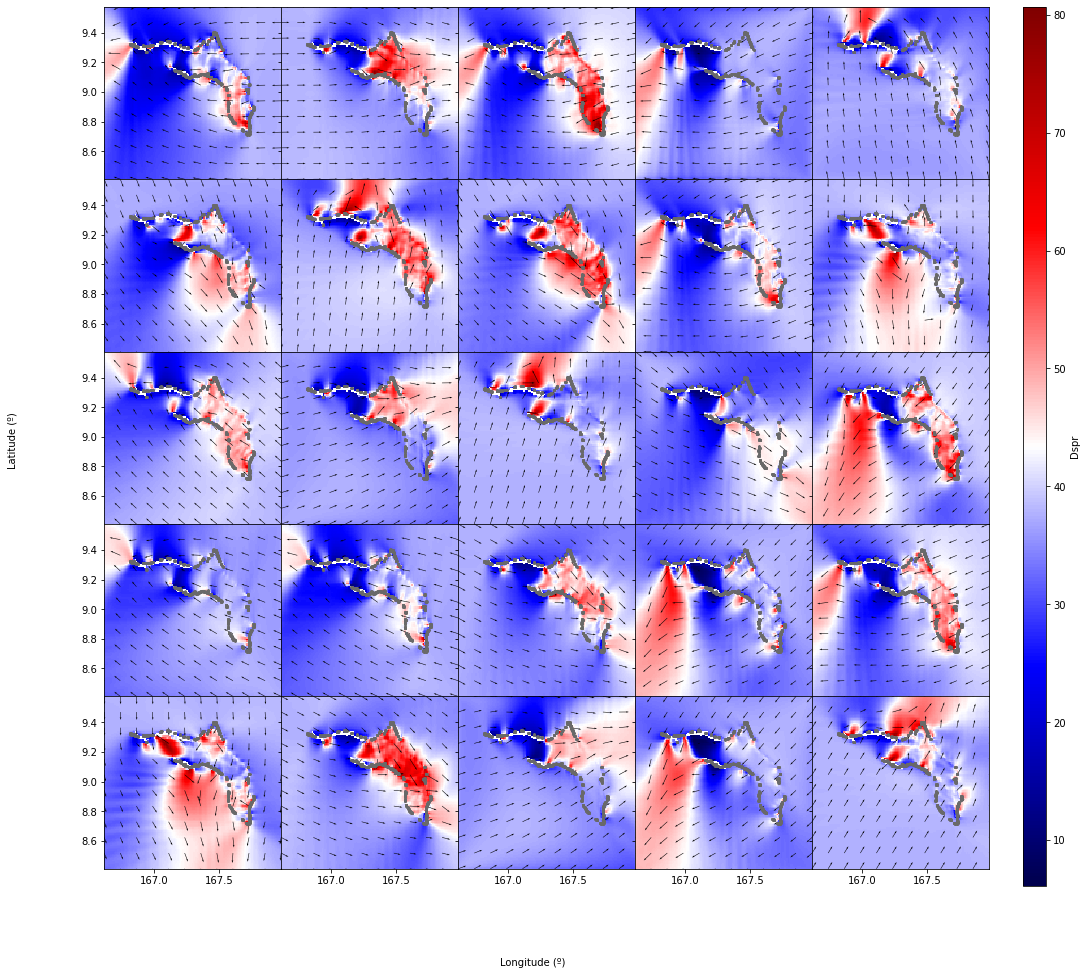

In [8]:
# extract output for main mesh
xds_out = sw.extract_output()
print(xds_out)

# plot scatter maps
scatter_maps(xds_out, n_cases=25, np_shore=np_shore);


<xarray.Dataset>
Dimensions:  (case: 125, lat: 80, lon: 120)
Coordinates:
  * lat      (lat) float64 9.351 9.351 9.353 9.354 ... 9.427 9.428 9.429 9.43
  * lon      (lon) float64 167.4 167.4 167.4 167.4 ... 167.5 167.5 167.5 167.5
Dimensions without coordinates: case
Data variables:
    Hsig     (case, lon, lat) float32 3.1358106 3.2392836 ... 0.44172767
    Tm02     (case, lon, lat) float32 10.816091 10.763387 ... 4.596888 4.645682
    Dir      (case, lon, lat) float32 54.12152 53.20175 ... 224.1397 215.06822
    Dspr     (case, lon, lat) float32 38.521225 37.65579 ... 50.507385 31.956343
    TPsmoo   (case, lon, lat) float32 11.766738 11.7511835 ... 4.724919


/Users/nico/Projects/BlueMath/HyWaves/venv/lib/python3.7/site-packages/matplotlib/colors.py:1061: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


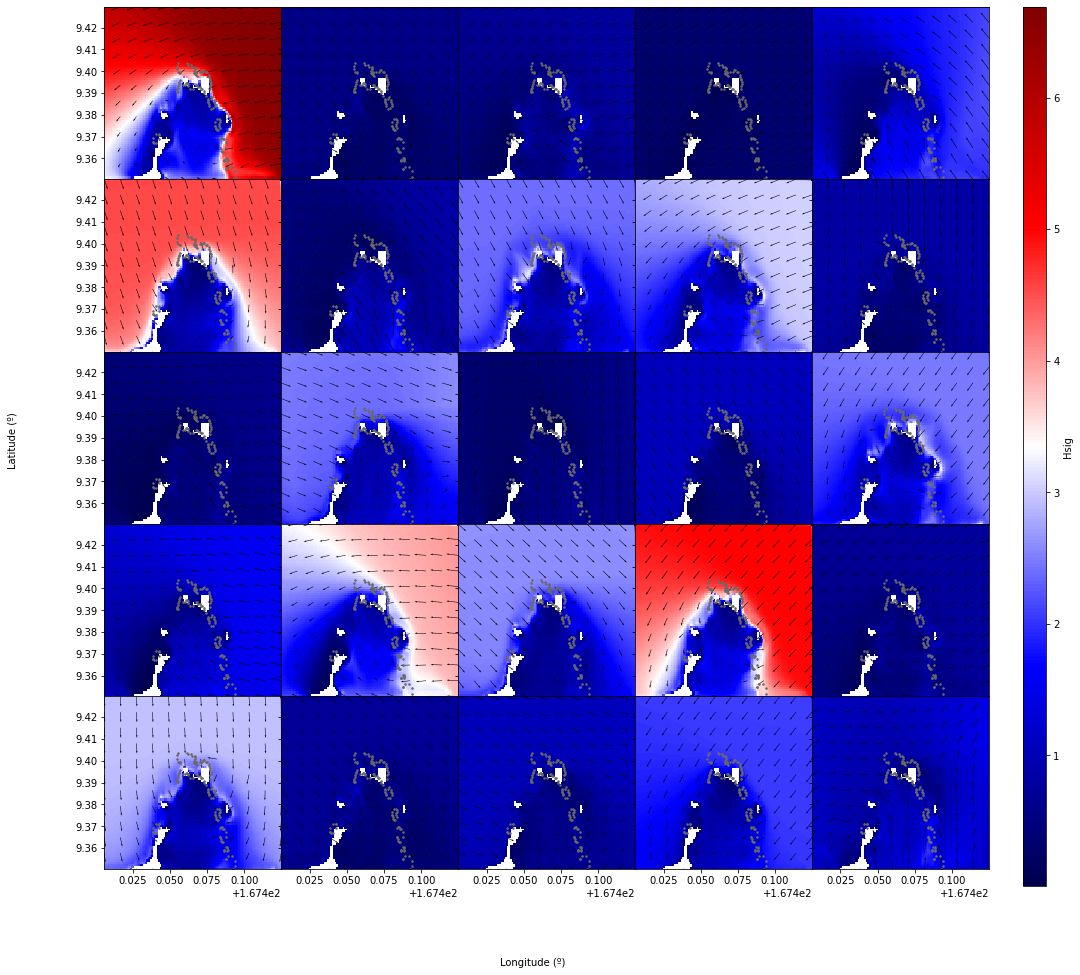

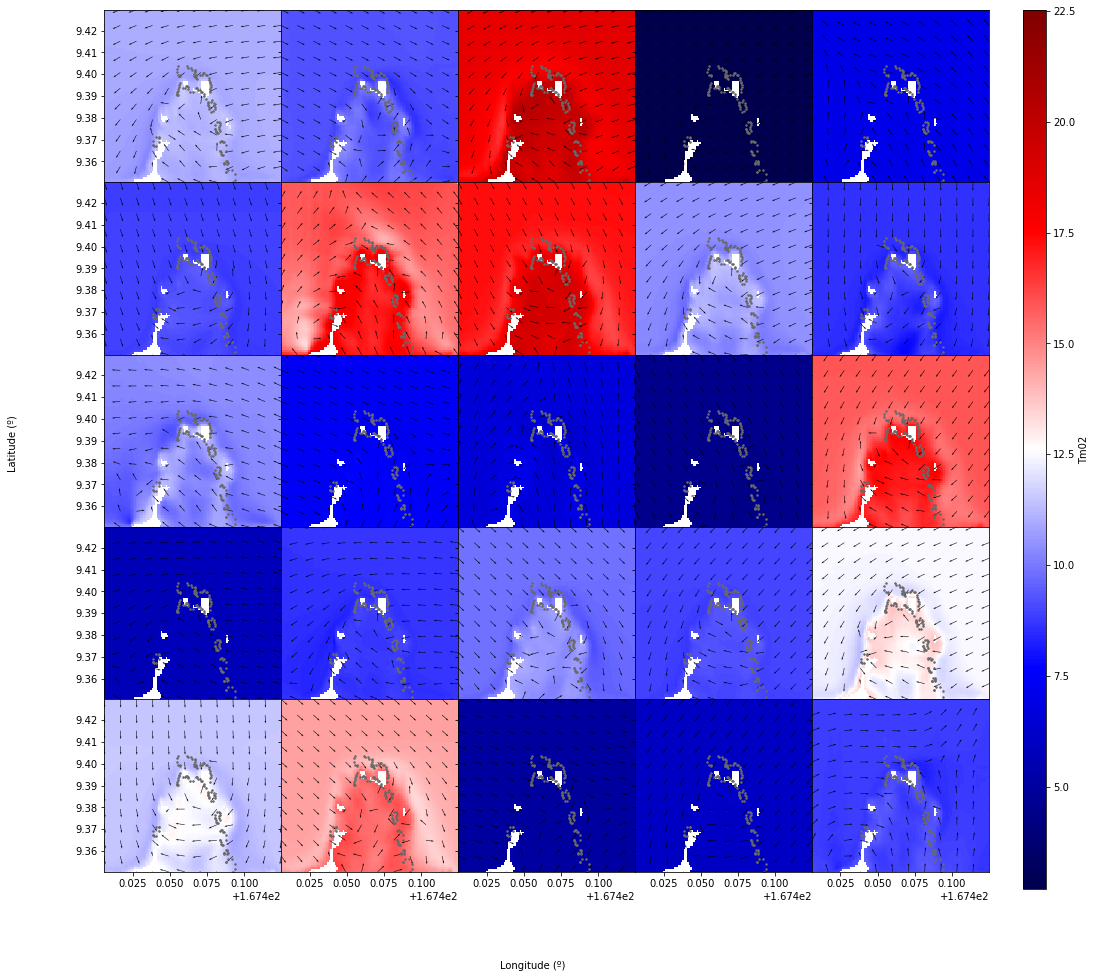

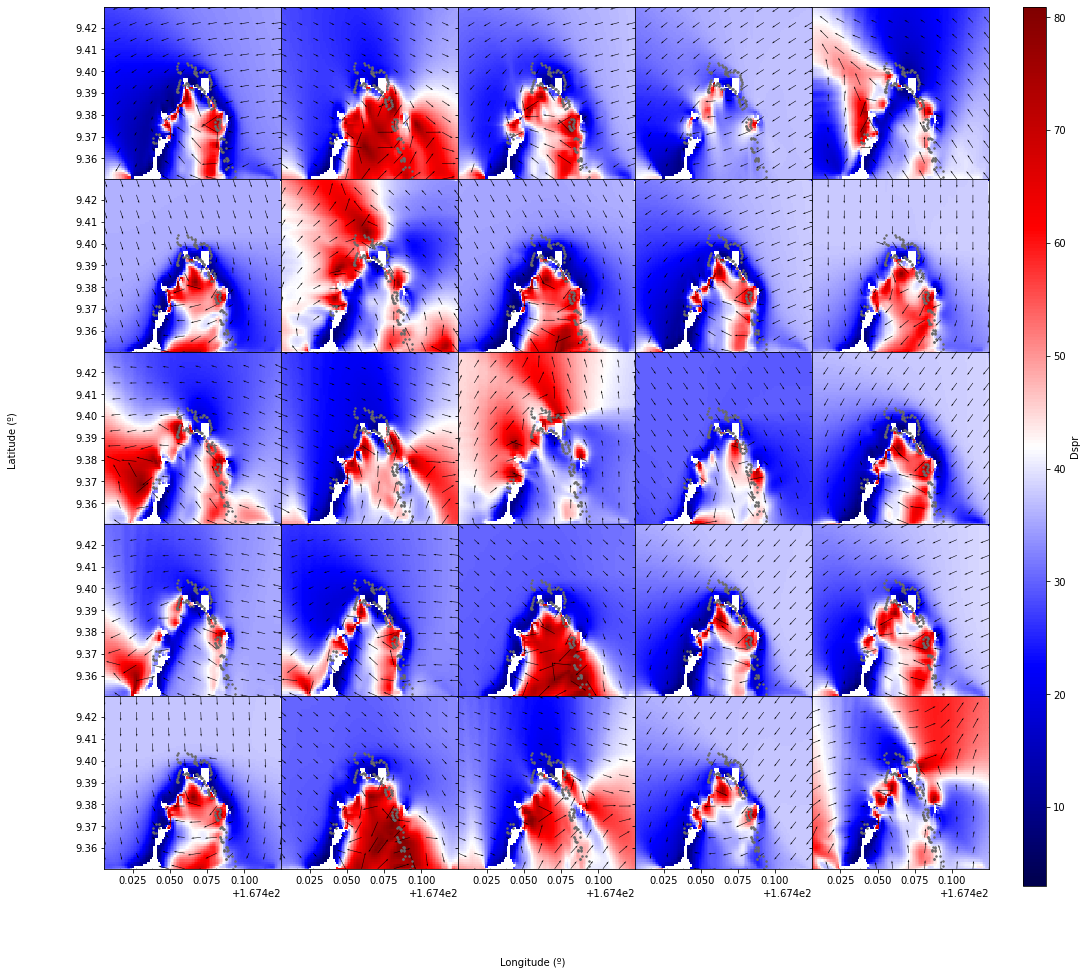

In [9]:
# extract output for nested mesh
xds_out_n1 = sw.extract_output(mesh=sp.mesh_nest1)
print(xds_out_n1)

# plot scatter maps
scatter_maps(xds_out_n1, n_cases=25, np_shore=np_shore);


## SWAN: extract output at a selected point 

In [10]:
# point to reconstruct 
ix_lon, ix_lat = 62, 66

# Extract propagated waves at point (from nest1 mesh)
target = xds_out_n1.isel({'lon':ix_lon, 'lat':ix_lat}).to_dataframe()

# this will be used as RBF target while fitting statistical model
print(target)


         lat       lon      Hsig       Tm02         Dir       Dspr     TPsmoo
case                                                                         
0     9.4165  167.4679  6.375265  11.036151   77.143402  31.548874  11.772887
1     9.4165  167.4679  0.550200   9.274467  298.254517  24.709164  10.734871
2     9.4165  167.4679  0.699937  18.444538   66.517395  31.917858  21.206932
3     9.4165  167.4679  0.343091   2.771857   55.386139  36.231720   2.777628
4     9.4165  167.4679  1.590056   7.005606  117.965729  18.110168   7.282711
...      ...       ...       ...        ...         ...        ...        ...
120   9.4165  167.4679  2.282557   7.864302   73.453522  34.141430   8.716818
121   9.4165  167.4679  0.875316  12.336402  299.684021  24.588478  14.269814
122   9.4165  167.4679  1.257696  10.423269  295.510376  23.189056  11.881736
123   9.4165  167.4679  2.020640   7.710339   94.479523  27.469999   8.259410
124   9.4165  167.4679  0.544619   4.537397  276.170288  32.0706

##  Radial Basis Function reconstruction

In [11]:
# Prepare data

subset.rename(columns={'per':'tp'}, inplace=True)  # reset subset variable name

# select dataset and subset variables
vns_ds = ['hs', 'tp', 'dir']

# select target variables
vns_tgt = ['Hsig', 'TPsmoo', 'Dir']

# subset - scalar / directional indexes
ix_scalar_subset = [0,1]      # scalar (hs, tp)
ix_directional_subset = [2]   # directional (dir)

# target - scalar / directional indexes
ix_scalar_target = [0,1]      # scalar (Hsig, Tpsmoo, Dir)
ix_directional_target = [2]   # directional (Dir)


In [12]:
# Obtain statistical propagation output for the entire waves dataset
output = RBF_Reconstruction(
    subset[vns_ds].values, ix_scalar_subset, ix_directional_subset,
    target[vns_tgt].values, ix_scalar_target, ix_directional_target,
    dataset[vns_ds].values,
)

# mount output as pandas.DataFrame
output = pd.DataFrame(data=output, columns=vns_tgt, index=dataset.index)

print(output)


ix_scalar: 0,  optimization: 1.93 | interpolation: 36.17
ix_scalar: 1,  optimization: 3.12 | interpolation: 36.95
ix_directional: 2,  optimization: 4.15 | interpolation: 72.47
                                   Hsig    TPsmoo        Dir
time                                                        
1979-01-01 00:59:59.999986560  0.343091  2.777628  55.386135
1979-01-01 02:00:00.000013440  0.589786  3.525231  58.517970
1979-01-01 03:00:00.000000000  0.792264  4.167576  62.082926
1979-01-01 03:59:59.999986560  0.947049  4.587265  63.774432
1979-01-01 05:00:00.000013440  1.080372  4.940389  64.309750
...                                 ...       ...        ...
2020-06-30 20:00:00.000013312  0.969083  7.949560  61.432075
2020-06-30 21:00:00.000000000  0.972861  7.953170  60.870374
2020-06-30 21:59:59.999986688  0.974845  7.955354  60.387914
2020-06-30 23:00:00.000013312  0.975851  7.951531  59.971061
2020-07-01 00:00:00.000000000  0.976452  7.944492  59.664608

[363768 rows x 3 columns]
